## <center> Sentiment Analysis on Movie Reviews

In [2]:
#Import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
%matplotlib inline
import seaborn as sb

#Text Processing Packages
import re
import bs4
from bs4 import BeautifulSoup as bs

#NLP packages
import nltk
# nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
# nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer

#Model packages
import keras
from keras.models import Sequential
from keras.layers import Dense, GlobalMaxPooling1D, Bidirectional, LSTM, Embedding, Dropout
from keras.preprocessing.text import Tokenizer
from sklearn.metrics import accuracy_score, f1_score, roc_curve, roc_auc_score
import gensim
from gensim.models import Word2Vec, Phrases
from keras.callbacks import ModelCheckpoint

In [3]:
#Filter Warnings
import warnings
warnings.filterwarnings('ignore')

In [4]:
#Read dataset
df_train = pd.read_csv('data/LabeledTrainData.tsv', delimiter='\t')
df_train.head()

,id,sentiment,review
0,5814_8,1,With all this stuff going down at the moment w...
1,2381_9,1,"\The Classic War of the Worlds\"" by Timothy Hi..."
2,7759_3,0,The film starts with a manager (Nicholas Bell)...
3,3630_4,0,It must be assumed that those who praised this...
4,9495_8,1,Superbly trashy and wondrously unpretentious 8...


In [5]:
#Read test dataset
df_test = pd.read_csv('data/testData.tsv', delimiter='\t')
df_test.head()

,id,review
0,12311_10,Naturally in a film who's main themes are of m...
1,8348_2,This movie is a disaster within a disaster fil...
2,5828_4,"All in all, this is a movie for kids. We saw i..."
3,7186_2,Afraid of the Dark left me with the impression...
4,12128_7,A very accurate depiction of small time mob li...


In [6]:
df_train.shape, df_test.shape

((25000, 3), (25000, 2))

In [7]:
#Let's backup both dataset
df_train_copy = df_train.copy()
df_test_copy = df_test.copy()

In [8]:
#Let's create a function to clean the data
def clean_text(text):
    #Steps - convert to lower, remove non-words, remove digits, remove single letters, remove spaces, remove stopwords
    text = bs(text, 'lxml').get_text() #remove html tags
    text = text.lower()
    text = re.sub('\W', ' ', text)
    text = re.sub('\d+', ' ', text)
    text = re.sub('\s+[a-z]\s+', ' ', text)
    text = re.sub('\s+', ' ', text)
    text = re.sub('^\s','', text) #Remove space from beginning of text
    text = re.sub('\s$','', text) #Remove space from end of text    
    text = text.split(' ')
    text = [word for word in text if word not in stop_words]
    text = [WordNetLemmatizer().lemmatize(word) for word in text] #additional lemmatize the words
    text = ' '.join(text)
    return text

In [9]:
#Let's test the clean text function
temp = df_train.loc[0,'review']
temp

"With all this stuff going down at the moment with MJ i've started listening to his music, watching the odd documentary here and there, watched The Wiz and watched Moonwalker again. Maybe i just want to get a certain insight into this guy who i thought was really cool in the eighties just to maybe make up my mind whether he is guilty or innocent. Moonwalker is part biography, part feature film which i remember going to see at the cinema when it was originally released. Some of it has subtle messages about MJ's feeling towards the press and also the obvious message of drugs are bad m'kay.<br /><br />Visually impressive but of course this is all about Michael Jackson so unless you remotely like MJ in anyway then you are going to hate this and find it boring. Some may call MJ an egotist for consenting to the making of this movie BUT MJ and most of his fans would say that he made it for the fans which if true is really nice of him.<br /><br />The actual feature film bit when it finally sta

In [10]:
clean_text(temp)

'stuff going moment mj started listening music watching odd documentary watched wiz watched moonwalker maybe want get certain insight guy thought really cool eighty maybe make mind whether guilty innocent moonwalker part biography part feature film remember going see cinema originally released subtle message mj feeling towards press also obvious message drug bad kay visually impressive course michael jackson unless remotely like mj anyway going hate find boring may call mj egotist consenting making movie mj fan would say made fan true really nice actual feature film bit finally start minute excluding smooth criminal sequence joe pesci convincing psychopathic powerful drug lord want mj dead bad beyond mj overheard plan nah joe pesci character ranted wanted people know supplying drug etc dunno maybe hate mj music lot cool thing like mj turning car robot whole speed demon sequence also director must patience saint came filming kiddy bad sequence usually director hate working one kid let a

In [11]:
#Lets process all the review in train
df_train['cleaned_review'] = df_train['review'].apply(lambda x: clean_text(x))
df_train['cleaned_review'].head(3)

0    stuff going moment mj started listening music ...
1    classic war world timothy hines entertaining f...
2    film start manager nicholas bell giving welcom...
3    must assumed praised film greatest filmed oper...
4    superbly trashy wondrously unpretentious explo...
Name: cleaned_review, dtype: object

In [12]:
#Clean test dataset reviews
df_test['cleaned_review'] = df_test['review'].apply(lambda x: clean_text(x))
df_test['cleaned_review'].head(3)

0    naturally film main theme mortality nostalgia ...
1    movie disaster within disaster film full great...
2    movie kid saw tonight child loved one point ki...
3    afraid dark left impression several different ...
4    accurate depiction small time mob life filmed ...
Name: cleaned_review, dtype: object

### Building Word Vector

In [13]:
#Preprocessing data to input into wordvector
corpus_train = [review.split(' ') for review in df_train['cleaned_review']]

#### Function to review Word Vectors

In [14]:
def review_wv(WVector):
    lvocab = len(WVector.wv.vocab) #Let's check the vocabulary length
    print('\tLength of Vocabulary:',lvocab)
    
    #Word similarity test
    ta = WVector.wv.similarity('terrible', 'awesome')
    print('\tSimilarity between terrible, awesome:', ta*100)
    
    bg = WVector.wv.similarity('boy', 'girl')
    print('\tSimilarity between boy, girl:', bg*100)
    
    gb = WVector.wv.similarity('good', 'bad')
    print('\tSimilarity between good, bad:', gb*100)
    
    #Get similar words from wordvector
    test_words = ['good', 'bad', 'great']
    #Define subplots and layout
    plt.subplots(figsize=(20, 6))
    grid = plt.GridSpec(1, 3)

    for i, eachword in enumerate(test_words):   
        sword = WVector.wv.similar_by_word(eachword)

        #Define x, y as list
        x=[]
        y=[]
        for eachval in sword[:5]:
            x.append(eachval[0])
            y.append(round(eachval[1]*100))

        #Plot the graph
        plt.subplot(grid[0,i])
        plt.bar(x = x, height=y)
        plt.title('Similar Word for - '+str(eachword))
    plt.show();

#### Simple Word Vector

In [15]:
WordVector = Word2Vec(sentences=corpus_train, min_count=4, size=300)

	Length of Vocabulary: 28626
	Similarity between terrible, awesome: 55.2078902721405
	Similarity between boy, girl: 84.71958637237549
	Similarity between good, bad: 64.44664597511292


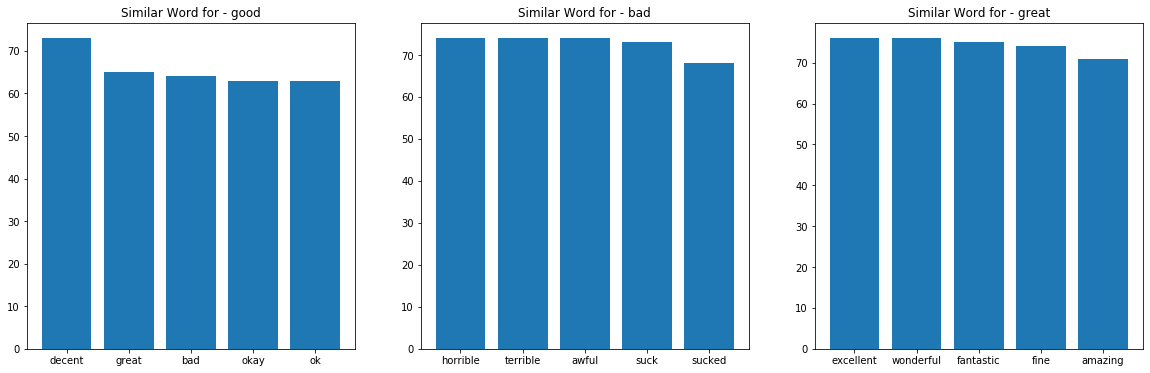

In [16]:
review_wv(WordVector)

In [17]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

In [18]:
tokenizer = Tokenizer(num_words=6000)
tokenizer.fit_on_texts(df_train['cleaned_review'])

In [19]:
X_train = tokenizer.texts_to_sequences(df_train['cleaned_review'])

In [20]:
X_train = pad_sequences(sequences=X_train, maxlen=300, padding='post')

In [21]:
y_train = df_train['sentiment']

In [22]:
X_test = tokenizer.texts_to_sequences(df_test['cleaned_review'])
X_test = pad_sequences(sequences=X_test, maxlen=300, padding='post')

### Building Neural Network Model

In [23]:
#Model using Simple WordVector
model = Sequential()
model.add(Embedding(6000, 128))
model.add(Bidirectional(LSTM(32, recurrent_dropout=0.1, return_sequences=True)))
model.add(GlobalMaxPooling1D())
model.add(Dense(32, activation='relu'))
model.add(Dropout(rate = 0.2))
model.add(Dense(1, activation='sigmoid'))
checkpointer = ModelCheckpoint(filepath='SWordVec_Model.hdf5', verbose=2, save_best_only=True)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

#Train the model
history = model.fit(X_train, y_train, batch_size=200, epochs=10, validation_split=0.3, callbacks=[checkpointer], verbose=1)
# model.fit(X_train, y_train, batch_size=200, epochs=10, validation_split=0.3, )

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Train on 17500 samples, validate on 7500 samples
Epoch 1/10
17500/17500 [==============================] - 199s 11ms/step - loss: 0.5379 - acc: 0.7357 - val_loss: 0.3199 - val_acc: 0.8703

Epoch 00001: val_loss improved from inf to 0.31988, saving model to SWordVec_Model.hdf5
Epoch 2/10
17500/17500 [==============================] - 199s 11ms/step - loss: 0.2697 - acc: 0.8966 - val_loss: 0.3018 - val_acc: 0.8720

Epoch 00002: val_loss improved from 0.31988 to 0.30175, saving model to SWordVec_Model.hdf5
Epoch 3/10
17500/17500 [==============================] - 199s 11ms/step - loss: 0.2005 - acc: 0.9243 - val_loss: 0.3102 - val_acc: 0.8719

Epoch 00003: val_loss did not improve 

In [24]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 128)         768000    
_________________________________________________________________
bidirectional_1 (Bidirection (None, None, 64)          41216     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                2080      
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 811,329
Trainable params: 811,329
Non-trainable params: 0
________________________________________________

In [ ]:
#Model version 2
model = Sequential()
model.add(Embedding(6000, 128))
model.add(Bidirectional(LSTM(128, recurrent_dropout=0.1)))
model.add(Dropout(0.25))
model.add(Dense(64))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
checkpointer = ModelCheckpoint(filepath='SWordVec_Model2.hdf5', verbose=2, save_best_only=True)

#Train the model
history = model.fit(X_train, y_train, batch_size=200, epochs=10, validation_split=0.3, callbacks=[checkpointer], verbose=1)

Train on 17500 samples, validate on 7500 samples
Epoch 1/10
17500/17500 [==============================] - 1421s 81ms/step - loss: 0.5227 - acc: 0.7292 - val_loss: 0.4113 - val_acc: 0.8175

Epoch 00001: val_loss improved from inf to 0.41133, saving model to SWordVec_Model2.hdf5
Epoch 2/10
17500/17500 [==============================] - 1450s 83ms/step - loss: 0.3075 - acc: 0.8762 - val_loss: 0.3184 - val_acc: 0.8731

Epoch 00002: val_loss improved from 0.41133 to 0.31845, saving model to SWordVec_Model2.hdf5
Epoch 3/10
17500/17500 [==============================] - 1491s 85ms/step - loss: 0.2252 - acc: 0.9153 - val_loss: 0.3449 - val_acc: 0.8653

Epoch 00003: val_loss did not improve from 0.31845
Epoch 4/10
17500/17500 [==============================] - 1421s 81ms/step - loss: 0.1926 - acc: 0.9278 - val_loss: 0.4142 - val_acc: 0.8693

Epoch 00004: val_loss did not improve from 0.31845
Epoch 5/10
17500/17500 [==============================] - 1407s 80ms/step - loss: 0.1677 - acc: 0.9368 